####### Loading Required Modules for this Project

In [2]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import DataFrame

In [3]:
##import json
import requests
import os
import sys
import datetime

**use only once under code mode**

!pip install tweepy

In [4]:
import tweepy

# Data wrangling

## Gathering Data

**Loading data from manually downloaded file : 'twitter-archive-enhanced.csv'**

In [5]:
twitterArchive_df = pd.read_csv("twitter-archive-enhanced.csv")

**Downloading 'image-predictions.tsv' programmatically**

In [6]:
URL = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(URL)
if response.status_code == 200:
    with open(URL.split("/")[-1],"wb") as f:
        f.write(response.content)
else:
    print("Error in File Downloading!")
    sys.exit()

In [7]:
# After Downloading successfully , loading data from 'image-predictions.tsv' file

imagePredict_df = pd.read_csv('image-predictions.tsv',sep="\t")

** Fetching tweet information using 'tweepy' python module & then saving data to a text file ** 

In [8]:
# tweepy api authentication
## .API() parameters : retry_count = 2, retry_delay =15, timeout = 30, wait_on_rate_limit = True, wait_on_rate_limit_notify = True

consumer_key = 'YOUR_consumer_key'
consumer_secret = 'YOUR_consumer_secret'
access_token = 'YOUR_access_token'
access_secret = 'YOUR_access_secret'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler = auth,retry_count = 2,retry_delay =10,timeout = 30,wait_on_rate_limit = True,wait_on_rate_limit_notify = True)


"consumer_key = 'YOUR_consumer_key'\nconsumer_secret = 'YOUR_consumer_secret'\naccess_token = 'YOUR_access_token'\naccess_secret = 'YOUR_access_secret'\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\napi = tweepy.API(auth_handler = auth,retry_count = 2,retry_delay =10,timeout = 30,wait_on_rate_limit = True,wait_on_rate_limit_notify = True)\n"

In [9]:
# For Testing Purpose Only

'''user = api.get_user('dog_rates')
print(user.screen_name)
print(user.followers_count)'''

"user = api.get_user('dog_rates')\nprint(user.screen_name)\nprint(user.followers_count)"

In [10]:
# get tweet_id's from 'tweet_id' column of DataFrame twitterArchive_df

tweet_ids = list(twitterArchive_df.tweet_id.astype('str'))
#len(tweet_ids)

In [11]:
# There are total 2356 tweet_ids present.

[Important!] Run below code multiple times ,iff there are some unexpected exceptions occurs during data fetching.

In [12]:
# keeping track of the 'tweet_id' which were already been recorded on 'tweet_json.txt' file
## This would help to resume the task from where it left(due to any unexpected api error or Internet connectivity)

tweet_id_done = []
#tweet_api_error = []
tweet_id_not_found =[]
if os.path.exists("tweet_json.txt"):
    lines = open("tweet_json.txt").readlines()
    for line in lines[1:]:
        tw_id,rtweet_count,fav_count = line.strip().split(",")
        tweet_id_done.append(tw_id)
else:
    with open("tweet_json.txt","w+") as fwrt:
        fwrt.write("tweet_id,retweet_count,favorite_count\n")
        
    
# Below code organized in such a way , that if we got an exception from 'tweepy.TweepError' other than 'No status found with that ID.' ; and if we re-run the for loop ,it will recheck status of those skipped tweet_id(s) to make sure if really some issues exist for those skipped tweet_id(s).

for idx1,tweet_id in enumerate(tweet_ids[:]):
    
    if tweet_id not in tweet_id_done :  # considering only 'tweet_id' those status are not yet beeing fetched 
        start = datetime.datetime.now().replace(microsecond=0)
        
        try:
            status = api.get_status(tweet_id, tweet_mode='extended')
            with open("tweet_json.txt","a+") as fwrt:
                fwrt.write("%s,%s,%s\n"%(tweet_id,status._json['retweet_count'],status._json['favorite_count'])) #status.favorite_count,status.retweet_count would do the same
            tweet_id_done.append(tweet_id)
        except tweepy.TweepError as e:
            if e.api_code == 144: # 144 => No status found with that ID ## e.response would return 404
                print("[Error] No status found with status ID %s"%tweet_id)
                with open("tweet_json.txt","a+") as fwrt:
                    fwrt.write("%s,Not Exist,Not Exist\n"%tweet_id)
                tweet_id_done.append(tweet_id)
                tweet_id_not_found.append(tweet_id)
            else:
                #tweet_api_error.append(tweet_id)
                print("[Error] Api Error(Code:%s) for %s" %(e.api_code,tweet_id)) 
                continue
        except:
            print("[Error] %s Not Opening" %tweet_id)
            #break
            continue
        
        end = datetime.datetime.now().replace(microsecond=0)
        print("[%s] %s . It took %s seconds" %(idx1+1,tweet_id,(end-start).total_seconds()))
        
    else:
        pass


'\ntweet_id_done = []\n#tweet_api_error = []\ntweet_id_not_found =[]\nif os.path.exists("tweet_json.txt"):\n    lines = open("tweet_json.txt").readlines()\n    for line in lines[1:]:\n        tw_id,rtweet_count,fav_count = line.strip().split(",")\n        tweet_id_done.append(tw_id)\nelse:\n    with open("tweet_json.txt","w+") as fwrt:\n        fwrt.write("tweet_id,retweet_count,favorite_count\n")\n        \n    \n# Below code organized in such a way , that if we got an exception from \'tweepy.TweepError\' other than \'No status found with that ID.\' ; and if we re-run the for loop ,it will recheck status of those skipped tweet_id(s) to make sure if really some issues exist for those skipped tweet_id(s).\n\nfor idx1,tweet_id in enumerate(tweet_ids[:]):\n    \n    if tweet_id not in tweet_id_done :  # considering only \'tweet_id\' those status are not yet beeing fetched \n        start = datetime.datetime.now().replace(microsecond=0)\n        \n        try:\n            status = api.get

In [13]:
try:
    tweet_id_not_found
except:
    pass

In [14]:
# there are 11 'tweet_id' ,where status are not found. Probably deleted.

Now creating DataFrame from 'tweet_json.txt' file

In [15]:
# creating DataFrame using append method with the help of Series

tweetOtherInfo_df = DataFrame()
with open('tweet_json.txt','r') as frd:
    column_names = frd.readline().strip().split(",")
    for line in frd.readlines():
        tweetOtherInfo_df = tweetOtherInfo_df.append(Series({key:value for key,value in zip(column_names,line.strip().split(","))}),ignore_index=True)


In [16]:
# changing column order 

tweetOtherInfo_df = tweetOtherInfo_df[['tweet_id','retweet_count','favorite_count']]

In [17]:
# Save DataFrame to a .csv file & skipping index column (Not required for this Project though)

##tweetOtherInfo_df.to_csv("tweet-other-info.csv",index=0)

___

## Assessing Data ( <font color=green>Iteration - 1</font> )

### <font color=darkred>Visual Assessment</font>

In [18]:
# Lets visualize 60 sample datapoints from each dataset
twitterArchive_df.head(60)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [19]:
imagePredict_df.tail(60)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2015,879492040517615616,https://pbs.twimg.com/media/DDSVWMvXsAEgmMK.jpg,1,German_short-haired_pointer,0.479896,True,vizsla,0.124353,True,bath_towel,0.073320,False
2016,879862464715927552,https://pbs.twimg.com/media/DDXmPrbWAAEKMvy.jpg,3,basset,0.813507,True,beagle,0.146654,True,cocker_spaniel,0.009485,True
2017,880095782870896641,https://pbs.twimg.com/media/DDa6ckbXgAAM1vV.jpg,1,miniature_pinscher,0.120298,True,Rhodesian_ridgeback,0.106395,True,beagle,0.106073,True
2018,880221127280381952,https://pbs.twimg.com/media/DDcscbXU0AIfDzs.jpg,1,Chihuahua,0.238525,True,meerkat,0.104256,False,clumber,0.052580,True
2019,880465832366813184,https://pbs.twimg.com/media/DDgK-J4XUAIEV9W.jpg,1,golden_retriever,0.913255,True,Labrador_retriever,0.026329,True,cocker_spaniel,0.009371,True
2020,880872448815771648,https://pbs.twimg.com/media/DDl8zzJW0AAisCJ.jpg,1,Pembroke,0.791416,True,Norwich_terrier,0.061393,True,Chihuahua,0.033726,True
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2023,881536004380872706,https://pbs.twimg.com/ext_tw_video_thumb/88153...,1,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False
2024,881666595344535552,https://pbs.twimg.com/media/DDxPFwbWAAEbVVR.jpg,1,Saluki,0.529012,True,Afghan_hound,0.250003,True,golden_retriever,0.160739,True


In [20]:
tweetOtherInfo_df.sample(60)

,tweet_id,retweet_count,favorite_count
1762,675845657354215424,970,2423
2106,670468609693655041,89,364
2023,671896809300709376,4422,8814
40,883482846933004288,10100,46130
855,761672994376806400,32525,53870
837,765395769549590528,3796,28640
436,819588359383371776,2216,10412
225,848324959059550208,5007,26186
413,822244816520155136,11092,38130
585,798705661114773508,7514,0


### <font color=dark red>Programmatic Assessment</font>

#### `twitter-archive` table
Table loaded into DataFrame: twitterArchive_df

In [21]:
twitterArchive_df.count()

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2356
source                        2356
text                          2356
retweeted_status_id            181
retweeted_status_user_id       181
retweeted_status_timestamp     181
expanded_urls                 2297
rating_numerator              2356
rating_denominator            2356
name                          2356
doggo                         2356
floofer                       2356
pupper                        2356
puppo                         2356
dtype: int64

In [22]:
# many variables of the dataframe,such as 'in_reply_to_status_id' , 'in_reply_to_user_id' , 'retweeted_status_id' , 'retweeted_status_user_id'
#,'retweeted_status_timestamp' & 'expanded_urls' filled with NaN

In [23]:
len(twitterArchive_df)

2356

In [24]:
twitterArchive_df.shape

(2356, 17)

In [25]:
# So there are 2356 datapoints/rows/observation present in the dataset

In [26]:
twitterArchive_df.tweet_id.is_unique

True

In [27]:
twitterArchive_df.tweet_id.value_counts().count()

2356

In [28]:
# Custom function to display only unique column names of a DataFrame

def print_unique_columns(df):
    for column in list(df.columns):
        if df[column].value_counts().count() == len(df):
            print (column)

In [29]:
print_unique_columns(twitterArchive_df)

tweet_id
timestamp
text


In [30]:
# 'tweet_id','timestamp' & 'text' columns have 2356 unique values

In [31]:
twitterArchive_df.index

RangeIndex(start=0, stop=2356, step=1)

In [32]:
twitterArchive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [33]:
twitterArchive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [34]:
twitterArchive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [35]:
# Exploring data types of several pandas objects

In [36]:
type(twitterArchive_df.timestamp.iloc[0])

str

In [37]:
type(twitterArchive_df.retweeted_status_timestamp[twitterArchive_df.retweeted_status_timestamp.notnull()].iloc[0])

str

In [38]:
twitterArchive_df.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Lola          10
Tucker        10
Bo             9
Winston        9
Sadie          8
the            8
Toby           7
Buddy          7
Bailey         7
an             7
Daisy          7
Leo            6
Scout          6
Jax            6
Stanley        6
Rusty          6
Koda           6
Jack           6
Oscar          6
Milo           6
Dave           6
Bella          6
Sunny          5
            ... 
Cermet         1
Florence       1
Juckson        1
Karma          1
Mingus         1
Lili           1
Cecil          1
Oreo           1
Barney         1
Darla          1
Perry          1
Grady          1
Millie         1
Sojourner      1
Dex            1
Dot            1
Storkson       1
Dwight         1
Rover          1
Shooter        1
Brudge         1
Brockly        1
Pip            1
Mairi          1
Rose           1
by             1
Kaiya          1
Teddy         

In [39]:
# 745 rows of 'name' column have None values

In [40]:
##twitterArchive_df.in_reply_to_user_id[~twitterArchive_df.in_reply_to_user_id.isnull()].astype("int64").describe()

In [41]:
for text_ in twitterArchive_df.text[:10]:
    print(text_+"\n")

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU

This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV

This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB

This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ

This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f

Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh

Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below

https://t.co/Zr4hWfAs1H http

In [42]:
# Above text is a preview of only first 10 value of 'text' column  

In [43]:
twitterArchive_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [44]:
# 'puppo' column has 2326 rows with None values & 30 rows with puppo values

In [45]:
sum(~twitterArchive_df.puppo.duplicated())
##twitterArchive_df[twitterArchive_df.puppo.duplicated()]

2

In [46]:
# Above output implies that the 'puppo' column is consist of only two type of values : None & puppo itself.

In [47]:
twitterArchive_non_None = twitterArchive_df[~twitterArchive_df.name.isin(['None'])]
twitterArchive_non_None.shape

(1611, 17)

In [48]:
# 'name' column has 1611 rows with non null values

In [49]:
sum(twitterArchive_non_None.name.duplicated())

655

In [50]:
# in 'name' column there are 655 duplicated values

In [51]:
##twitterArchive_non_None[twitterArchive_non_None.name.duplicated()]
##twitterArchive_non_None[twitterArchive_non_None.name.duplicated()].name.value_counts()
twitterArchive_non_None[twitterArchive_non_None.name.duplicated()].name.value_counts().sort_values(ascending=False).head(60)

a           54
Charlie     11
Lucy        10
Oliver      10
Cooper      10
Lola         9
Penny        9
Tucker       9
Bo           8
Winston      8
the          7
Sadie        7
Daisy        6
Buddy        6
Toby         6
Bailey       6
an           6
Bella        5
Rusty        5
Jax          5
Leo          5
Scout        5
Oscar        5
Dave         5
Stanley      5
Koda         5
Milo         5
Jack         5
Phil         4
Sammy        4
Finn         4
Gus          4
Sunny        4
George       4
Larry        4
Bentley      4
very         4
Alfie        4
Oakley       4
Chester      4
Louis        4
Hank         3
Jerry        3
Duke         3
Brody        3
Reggie       3
Dexter       3
Derek        3
Reginald     3
Boomer       3
Bruce        3
Chip         3
Winnie       3
Ruby         3
Carl         3
Sampson      3
Loki         3
one          3
Moose        3
Bear         3
Name: name, dtype: int64

In [52]:
# in 'name' column there are some inaccurate values such as a , an ,the,quite etc.

In [53]:
sum(twitterArchive_df.expanded_urls.duplicated())

137

In [54]:
# There are 137 duplicate value presents for 'expanded_urls' column/feature/variable

In [55]:
##twitterArchive_non_NaN = twitterArchive_df[~twitterArchive_df.expanded_urls.isnull()]
sum(twitterArchive_df.expanded_urls.isnull()) # >>> output : 59

# OR , both works as same

twitterArchive_non_NaN = twitterArchive_df[~twitterArchive_df.expanded_urls.isin([np.nan])]
sum(twitterArchive_df.expanded_urls.isin([np.nan])) # >>> output : 59

59

In [56]:
sum(twitterArchive_non_NaN.expanded_urls.str.startswith("http")) # >>> output : 2297

2297

In [57]:
twitterArchive_df.shape[0] == 2297+59

True

In [58]:
#So it is proven all non NaN entries of the column 'expanded_urls' are actually urls

__________

#### `image-prediction` table
Table loaded into DataFrame: imagePredict_df 

In [59]:
imagePredict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [60]:
imagePredict_df.index

RangeIndex(start=0, stop=2075, step=1)

In [61]:
imagePredict_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [62]:
imagePredict_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [63]:
imagePredict_df.shape

(2075, 12)

In [64]:
# This DataFrame has 2075 rows/observations

In [65]:
imagePredict_df.tweet_id.is_unique

True

In [66]:
# Finding column with unique values only :-
print_unique_columns(imagePredict_df)

tweet_id


In [67]:
# 'tweet_id' column has 2075 unique values

In [68]:
imagePredict_df.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [69]:
# 'img_num' column dont have any missing value.

In [70]:
imagePredict_df.p1.value_counts().sort_values()

ibex                           1
dining_table                   1
electric_fan                   1
microwave                      1
microphone                     1
syringe                        1
tailed_frog                    1
mortarboard                    1
hay                            1
skunk                          1
padlock                        1
pillow                         1
sea_urchin                     1
cowboy_boot                    1
radio_telescope                1
tiger_shark                    1
book_jacket                    1
agama                          1
tick                           1
standard_schnauzer             1
hand_blower                    1
orange                         1
water_bottle                   1
teapot                         1
jersey                         1
coffee_mug                     1
binoculars                     1
hammer                         1
carton                         1
lorikeet                       1
          

In [71]:
# Image Prediction Algotithm predict highest number of dogs as 'golden_retriever' type. Second highest dog type is 'Labrador_retriever'.

In [72]:
sum(imagePredict_df.jpg_url.str.startswith("http"))

2075

In [73]:
imagePredict_df.shape[0] == sum(imagePredict_df.jpg_url.str.startswith("http"))

True

In [74]:
#So it is proven all entries of the column 'jpg_url' are actually urls

In [75]:
#If I need to consider only dog pictures, then either imagePredict_df.p1_dog is True or imagePredict_df.p2_dog is True or imagePredict_df.p3_dog is True

tmp = imagePredict_df[(imagePredict_df.p1_dog == True) | (imagePredict_df.p2_dog == True) | (imagePredict_df.p3_dog == True)]

tmp.shape

(1751, 12)

In [76]:
#So tmp DataFrame containing only Dog related tweets

In [77]:
sum((tmp.p1_conf>tmp.p2_conf) & (tmp.p2_conf>tmp.p3_conf))

1751

In [78]:
## So p1_conf > p2_conf > p3_conf is the order of a picture confidence level(probabilty) for the Image Predction Algorithm.

In [79]:
#in tmp2 DataFrame either p1_dog is set to True or p2_dog & p3_dog are set to True where p1_dog is set to False.

tmp2 = tmp[((tmp.p1_dog == True) | ((tmp.p1_dog == False) & (tmp.p2_dog == True) & (tmp.p3_dog == True)))]

sum((tmp2.p1_dog == True))

1532

In [80]:
sum((tmp2.p1_conf < tmp2.p2_conf + tmp2.p3_conf) & (tmp2.p1_dog == False))
##tmp2.shape # >>> 1633

24

In [81]:
#Above 24 implies, if a picture p1_dog set to False ,then there are 24 occasion ,where pictures p2_conf & p3_conf summation is bigger than p1_conf
# In the above case ,despite of p1_conf is set to False,there are 24 times ,when there is a greater probabilty that that its a dog image.

In [82]:
# Now I want to consider only those rows where either p1_conf is maximum along with other confidefence levels or summation of p2_conf & p3_conf is greater than p1_conf while p1_dog is not True. 
sum(((tmp2.p1_conf < tmp2.p2_conf + tmp2.p3_conf) & (tmp2.p1_dog == False)) | (tmp2.p1_dog == True))


1556

In [83]:
##sum(((tmp2.p1_conf > tmp2.p2_conf + tmp2.p3_conf) | (tmp2.p1_dog == True)) & (tmp2.p1_dog == False)) # >>> 77

#### `tweet-other-info` table

Table loaded into DataFrame: tweetOtherInfo_df 

In [84]:
tweetOtherInfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null object
retweet_count     2356 non-null object
favorite_count    2356 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


In [85]:
tweetOtherInfo_df.shape

(2356, 3)

In [86]:
# This DataFrame consists of 256 rows & 3 columns

In [87]:
tweetOtherInfo_df.index

RangeIndex(start=0, stop=2356, step=1)

In [88]:
tweetOtherInfo_df.columns

Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')

In [89]:
type(tweetOtherInfo_df.tweet_id.iloc[0])

str

In [90]:
type(tweetOtherInfo_df.retweet_count.iloc[0])

str

In [91]:
type(tweetOtherInfo_df.favorite_count.iloc[0])

str

In [92]:
# So, all columns are String type

In [93]:
print_unique_columns(tweetOtherInfo_df)

tweet_id


In [94]:
tweetOtherInfo_df.tweet_id.is_unique

True

In [95]:
# 'tweet_id' column has unique values

In [96]:
tweetOtherInfo_df.retweet_count.value_counts(ascending=False).head()

Not Exist    11
94            5
821           5
58            4
307           4
Name: retweet_count, dtype: int64

In [97]:
tweetOtherInfo_df.favorite_count.value_counts(ascending=False).head()

0            170
Not Exist     11
1754           3
513            3
480            3
Name: favorite_count, dtype: int64

In [98]:
# 'retweet_count' & 'favorite_count' column have some values filled with "Not Exist"

In [99]:
tweetOtherInfo_df.describe()

,tweet_id,retweet_count,favorite_count
count,2356,2356,2356
unique,2356,1748,1991
top,671488513339211776,Not Exist,0
freq,1,11,170


___

#### Quality isuue
##### `twitter-archive` table
- 'tweet_id' datatype is int64, require str(string)
- type of 'timestamp' and 'retweeted_status_timestamp' are str not Timestamp
- As per project description 'doggo' , 'floofer' , 'pupper' & 'puppo' columns have some missing values.
- need to fix consistency issue for 'doggo','floofer','pupper'& 'puppo' columns and then assign NaN , if one of its corresponding column already filled with non null value.

##### `image-prediction` table
- 'tweet_id' datatype is int64, require str(string)
- validate an image as a dog image if it meets certain requirements
- A new column 'type' could be created which will represent dog types. Its value would be consist of 'p1' column value when 'p1_dog' column is True ,otherwise mix.  

##### `tweet-other-info` table
- 'retweet_count' & 'favorite_count' column have some missing values : "Not Exist" . Need to get rid of those rows/observations from the table.
- 'retweet_count' & 'favorite_count' datatype are str(string) , required int64


#### Tidiness
##### `twitter-archive` table
- 'doggo' , 'floofer' , 'pupper' & 'puppo' are stage of dogs,so they should be under 1 column

##### `twitter-other-info` table
- 'retweet_count' & 'favorite_count' features should be the part of the `twitter-archive` table

## Cleaning Data ( <font color=green>Iteration - 1</font> )

###  <font color=red>Quality</font>

#### `twiter-archive` table

In [100]:
# making copies of dataframes
twitterArchive_df_clean = twitterArchive_df.copy()

##### converting 'tweet_id' type from int64 to str
DataFrame : `twitterArchive_df_clean` 

**Define**

use astype() to conver datatype of a column

**Code**

In [101]:
twitterArchive_df_clean.tweet_id = twitterArchive_df_clean.tweet_id.astype("str")

**Test**

In [102]:
twitterArchive_df_clean.tweet_id.dtype

dtype('O')

In [103]:
type(twitterArchive_df_clean.tweet_id.iloc[0])

str

##### converting 'timestamp' , 'retweeted_status_timestamp'  data types from str to Timestamp
DataFrame : `twitterArchive_df_clean` 

**Define**

Use to_datetime method of pandas module to convert appropriate string to Timestamp object.

No matter whether do you use fillna filter or not , all default NaN(Not a Number) values would be converted to NaT(Not a Time).

**Code**

In [104]:
twitterArchive_df_clean.timestamp = pd.to_datetime(twitterArchive_df_clean.timestamp)

In [105]:
##original_df_clean.retweeted_status_timestamp = pd.to_datetime(original_df_clean.retweeted_status_timestamp.fillna(""))
# OR
twitterArchive_df_clean.retweeted_status_timestamp = pd.to_datetime(twitterArchive_df_clean.retweeted_status_timestamp)

**Test**

In [106]:
twitterArchive_df_clean.timestamp.dtype

dtype('<M8[ns]')

In [107]:
type(twitterArchive_df_clean.timestamp.iloc[0])

pandas.tslib.Timestamp

In [108]:
twitterArchive_df_clean.retweeted_status_timestamp.dtype

dtype('<M8[ns]')

##### As per project description 'doggo' , 'floofer' , 'pupper' & 'puppo' columns have some missing values and accuracy issues
DataFrame : DataFrame : `twitterArchive_df_clean` 

**Define**

from 'text' column by .str through regular expression extract() , find out dog stages mentioned in the description text of each tweet.

**Code**

In [109]:
twitterArchive_df_clean.doggo = None
twitterArchive_df_clean.doggo = twitterArchive_df_clean.text.str.extract('\\b(doggo|Doggo)\\b', expand=True)[0]

In [110]:
##twitterArchive_df_clean.text.str.extract('(doggo|Doggo)', expand=True)[0].value_counts()
##sum(~twitterArchive_df_clean.doggo.isin([np.nan]))

In [111]:
twitterArchive_df_clean.puppo = None
twitterArchive_df_clean.puppo = twitterArchive_df_clean.text.str.extract('\\b(puppo|Puppo)\\b', expand=True)[0]

In [112]:
twitterArchive_df_clean.pupper = None
twitterArchive_df_clean.pupper = twitterArchive_df_clean.text.str.extract('\\b(pupper|Pupper)\\b', expand=True)[0]

In [113]:
twitterArchive_df_clean.floofer = None
twitterArchive_df_clean.floofer = twitterArchive_df_clean.text.str.extract('\\b(floofer|Floofer)\\b', expand=True)[0]

**Test**

In [114]:
twitterArchive_df_clean.doggo.value_counts()

doggo    86
Doggo     9
Name: doggo, dtype: int64

In [115]:
twitterArchive_df_clean.puppo.value_counts()

puppo    29
Name: puppo, dtype: int64

In [116]:
twitterArchive_df_clean.pupper.value_counts()

pupper    247
Pupper      7
Name: pupper, dtype: int64

In [117]:
twitterArchive_df_clean.floofer.value_counts()

Floofer    6
floofer    4
Name: floofer, dtype: int64

##### Need to fix consistency issue for 'doggo','floofer','pupper'& 'puppo' columns and then assign NaN , if one of its corresponding column already filled with non null value.
DataFrame : DataFrame : `twitterArchive_df_clean`

**Define**

use replace() to replace "Doggo" with "doggo",etc.
and to assign NaN , use np.nan

**Code**

In [118]:
twitterArchive_df_clean.doggo.replace("Doggo","doggo",inplace=True)
##t = {'doggo': True, np.nan: False}
##twitterArchive_df_clean.doggo = twitterArchive_df_clean.doggo.map(t)

In [119]:
twitterArchive_df_clean.floofer[twitterArchive_df_clean.doggo.notnull()] = np.nan
twitterArchive_df_clean.floofer.replace("Floofer","floofer",inplace=True)
##t = {'floofer': True, np.nan: False}
##twitterArchive_df_clean.floofer = twitterArchive_df_clean.floofer.map(t)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [120]:
twitterArchive_df_clean.pupper[twitterArchive_df_clean.doggo.notnull() | twitterArchive_df_clean.floofer.notnull()] = np.nan
twitterArchive_df_clean.pupper.replace("Pupper","pupper",inplace=True)
##t = {'pupper': True, np.nan: False}
##twitterArchive_df_clean.pupper = twitterArchive_df_clean.pupper.map(t)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [121]:
twitterArchive_df_clean.puppo[twitterArchive_df_clean.doggo.notnull() | twitterArchive_df_clean.floofer.notnull() | twitterArchive_df_clean.pupper.notnull()] = np.nan
twitterArchive_df_clean.puppo.replace("Puppo","puppo",inplace=True)
##t = {'puppo': True, np.nan: False}
##twitterArchive_df_clean.puppo = twitterArchive_df_clean.puppo.map(t)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


**Test**

In [122]:
##sum(twitterArchive_df_clean.doggo[twitterArchive_df_clean.doggo.notnull()])
twitterArchive_df_clean.doggo.count()

95

In [123]:
twitterArchive_df_clean.doggo.value_counts()

doggo    95
Name: doggo, dtype: int64

In [124]:
##sum(twitterArchive_df_clean.floofer[twitterArchive_df_clean.floofer.notnull()])
twitterArchive_df_clean.floofer.count()

9

In [125]:
twitterArchive_df_clean.floofer.value_counts()

floofer    9
Name: floofer, dtype: int64

In [126]:
##sum(twitterArchive_df_clean.pupper[twitterArchive_df_clean.pupper.notnull()])
twitterArchive_df_clean.pupper.count()

243

In [127]:
twitterArchive_df_clean.pupper.value_counts()

pupper    243
Name: pupper, dtype: int64

In [128]:
##sum(twitterArchive_df_clean.puppo[twitterArchive_df_clean.puppo.notnull()])
twitterArchive_df_clean.puppo.count()

28

In [129]:
twitterArchive_df_clean.puppo.value_counts()

puppo    28
Name: puppo, dtype: int64

___

#### `image-prediction` table

In [130]:
# making copies of dataframes
imagePredict_df_clean = imagePredict_df.copy()

##### converting 'tweet_id' type from int64 to str
DataFrame : `imagePredict_df_clean`  

**Define**

use astype() to conver datatype of a column

**Code**

In [131]:
imagePredict_df_clean.tweet_id = imagePredict_df_clean.tweet_id.astype("str")

**Test**

In [132]:
imagePredict_df_clean.tweet_id.dtype

dtype('O')

In [133]:
type(imagePredict_df_clean.tweet_id.iloc[0])

str

##### validate an image as a dog image if it meets certain requirements
DataFrame : `imagePredict_df_clean`  

**Define**

filter rows if either 'p1_dog' is True or 'p1_dog' is False ,but p2_conf+p3_conf > p1_conf

**Code**

In [134]:
tmp = imagePredict_df_clean[(imagePredict_df_clean.p1_dog == True) | (imagePredict_df_clean.p2_dog == True) | (imagePredict_df_clean.p3_dog == True)]

tmp2 = tmp[((tmp.p1_dog == True) | ((tmp.p1_dog == False) & (tmp.p2_dog == True) & (tmp.p3_dog == True)))]

imagePredict_df_clean = tmp2[((tmp2.p1_conf < tmp2.p2_conf + tmp2.p3_conf) & (tmp2.p1_dog == False)) | (tmp2.p1_dog == True)]

**Test**

In [135]:
imagePredict_df_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
11,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,Gordon_setter,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True


In [136]:
#out of 2075 rows only 1556 meets the requirement

In [137]:
imagePredict_df_clean.p1_dog[imagePredict_df_clean.p1_dog==True].count()

1532

In [138]:
imagePredict_df_clean.p1_dog[imagePredict_df_clean.p1_dog==False].count()

24

##### A new column 'type' could be created which will represent dog types. Its value would be consist of 'p1' column value when 'p1_dog' column is True ,otherwise mix.  

**Define**

**Code**

In [139]:
imagePredict_df_clean["type"] = None

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [140]:
# if p1_dog is True , we are copying corresponding 'p1' column values to 'type' column

imagePredict_df_clean.type[imagePredict_df_clean.p1_dog == True] = imagePredict_df_clean[imagePredict_df_clean.p1_dog == True].p1
##sum(imagePredict_df_clean.p1_dog == True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [141]:
imagePredict_df_clean.type.fillna("mix",inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**Test**

In [142]:
sum(imagePredict_df_clean.type.isnull())

0

In [143]:
sum(imagePredict_df_clean.type == "mix")

24

In [144]:
imagePredict_df_clean.type.value_counts()

golden_retriever               150
Labrador_retriever             100
Pembroke                        89
Chihuahua                       83
pug                             57
chow                            44
Samoyed                         43
toy_poodle                      39
Pomeranian                      38
malamute                        30
cocker_spaniel                  30
French_bulldog                  26
mix                             24
miniature_pinscher              23
Chesapeake_Bay_retriever        23
German_shepherd                 20
Siberian_husky                  20
Staffordshire_bullterrier       20
Cardigan                        19
Maltese_dog                     18
beagle                          18
Shetland_sheepdog               18
Eskimo_dog                      18
Rottweiler                      17
Shih-Tzu                        17
Lakeland_terrier                17
kuvasz                          16
Italian_greyhound               16
Great_Pyrenees      

In [145]:
imagePredict_df_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher


___

#### `tweet-other-info` table

In [146]:
# making copies of dataframes
tweetOtherInfo_df_clean = tweetOtherInfo_df.copy()

##### get rid of missing rows/observations from the table for column names : 'retweet_count' & 'favorite_count' 

DataFrame : `tweetOtherInfo_df_clean`  

**Define**

Use isin() for filtering out missing values("Not Exist") from each cloumn 

**Code**

In [147]:
tweetOtherInfo_df_clean = tweetOtherInfo_df_clean[~tweetOtherInfo_df_clean.retweet_count.isin(["Not Exist"])]

In [148]:
tweetOtherInfo_df_clean = tweetOtherInfo_df_clean[~tweetOtherInfo_df_clean.favorite_count.isin(["Not Exist"])]

**Test**

In [149]:
sum(tweetOtherInfo_df_clean.retweet_count.isin(["Not Exist"]))

0

In [150]:
sum(tweetOtherInfo_df_clean.favorite_count.isin(["Not Exist"]))

0

##### converting 'retweet_count' & 'favorite_count' types from str to int64

DataFrame : `tweetOtherInfo_df_clean`  

**Define**

Use .astype() to change the datatype of the column to int64 from str.

**Code**

In [151]:
tweetOtherInfo_df_clean.retweet_count = tweetOtherInfo_df_clean.retweet_count.astype("int64")

In [152]:
tweetOtherInfo_df_clean.favorite_count = tweetOtherInfo_df_clean.favorite_count.astype("int64")

**Test**

In [153]:
tweetOtherInfo_df_clean.retweet_count.dtype

dtype('int64')

In [154]:
tweetOtherInfo_df_clean.retweet_count.dtype

dtype('int64')

### <font color=red>Tidiness</font>

#### 'doggo' , 'floofer' , 'pupper' & 'puppo' are stage of dogs,so they should be under 1 column on `twiter-archive` table

**Define**

Create a new column called : stage
And assign it with any non null value of 'doggo' or 'floofer' or 'pupper' or 'puppo' columns.
And null values should be filled with NaN.
After that drop 'doggo' , 'floofer' , 'pupper' & 'puppo' columns

**Code**

In [155]:
twitterArchive_df_clean["stage"] = (twitterArchive_df_clean.doggo.fillna("")+twitterArchive_df_clean.floofer.fillna("")+twitterArchive_df_clean.pupper.fillna("")+twitterArchive_df_clean.puppo.fillna(""))

In [156]:
twitterArchive_df_clean["stage"] = twitterArchive_df_clean["stage"].replace("",np.nan)

In [157]:
#Dropping columns
twitterArchive_df_clean.drop("doggo",axis=1,inplace=True)
twitterArchive_df_clean.drop("floofer",axis=1,inplace=True)
twitterArchive_df_clean.drop("pupper",axis=1,inplace=True)
twitterArchive_df_clean.drop("puppo",axis=1,inplace=True)

**Test**

In [158]:
twitterArchive_df_clean.head(60)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


In [159]:
twitterArchive_df_clean["stage"].value_counts()

pupper     243
doggo       95
puppo       28
floofer      9
Name: stage, dtype: int64

#### column name 'retweet_count' & 'favorite_count'  should be part of the `twiter-archive` table

**Define**

Join/merge twitterArchive_df_clean DataFrame(twiter-archive table) with tweetOtherInfo_df_clean DataFrame(tweet-other-info table) on common column name 'tweet_id'.

Use .merge() function of the DataFrame to join other DataFrame. It would be a inner join.

After joining done, `tweet-other-info` table would not be of any usage.

**Code**

In [160]:
# how = 'inner' , by default
twitterArchive_df_clean = twitterArchive_df_clean.merge(tweetOtherInfo_df_clean,on="tweet_id")

**Test**

In [161]:
twitterArchive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,8636,38954
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,6345,33352
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4211,25129
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8756,42296
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9518,40452
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,3155,20291
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,2101,11898
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,19148,65801
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,4319,27866
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,7516,32051


In [162]:
# 11 tweet_id(s) are removed,as they are not present on both tables. 

## Assesment Data ( <font color=green>Iteration - 2</font> )

### <font color=darkred>Visual Assesment</font>

In [163]:
twitterArchive_df_clean.head(60)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,8636,38954
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,6345,33352
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4211,25129
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8756,42296
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9518,40452
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,3155,20291
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,2101,11898
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,19148,65801
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,4319,27866
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,7516,32051


In [164]:
imagePredict_df_clean.head(30)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,Bernese_mountain_dog
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,chow
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True,miniature_poodle
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True,golden_retriever
11,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,Gordon_setter,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True,Gordon_setter


### <font color=darkred>Programmatic Assasment</font>

In [165]:
twitterArchive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2344
Data columns (total 16 columns):
tweet_id                      2345 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2345 non-null datetime64[ns]
source                        2345 non-null object
text                          2345 non-null object
retweeted_status_id           170 non-null float64
retweeted_status_user_id      170 non-null float64
retweeted_status_timestamp    170 non-null datetime64[ns]
expanded_urls                 2286 non-null object
rating_numerator              2345 non-null int64
rating_denominator            2345 non-null int64
name                          2345 non-null object
stage                         374 non-null object
retweet_count                 2345 non-null int64
favorite_count                2345 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(4), object(6)
memory usa

In [166]:
twitterArchive_df_clean.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,7.800000e+01,7.800000e+01,1.700000e+02,1.700000e+02,2345.000000,2345.000000,2345.000000,2345.000000
mean,7.455079e+17,2.014171e+16,7.696241e+17,1.322044e+16,13.129211,10.457143,3041.183369,8095.368870
std,7.582492e+16,1.252797e+17,6.182856e+16,9.901337e+16,45.984063,6.760971,5056.113618,12176.523107
min,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,0.000000,0.000000
25%,6.757419e+17,3.086374e+08,7.122010e+17,4.196984e+09,10.000000,10.000000,609.000000,1407.000000
50%,7.038708e+17,4.196984e+09,7.787593e+17,4.196984e+09,11.000000,10.000000,1423.000000,3550.000000
75%,8.257804e+17,4.196984e+09,8.191724e+17,4.196984e+09,12.000000,10.000000,3544.000000,10013.000000
max,8.862664e+17,8.405479e+17,8.860537e+17,7.874618e+17,1776.000000,170.000000,77699.000000,143896.000000


In [167]:
print_unique_columns(twitterArchive_df_clean)

tweet_id
timestamp
text


In [168]:
##sum(tmp_df.expanded_urls.str.split("/").str[5] == tmp_df.tweet_id)

#### Quality isuue
##### `twitter-archive` table

- As per project description, need to filter out retweets
- As per project description 'name' column has some inaccurate values
- As per project description 'rating_numerator','rating_denominator' columns have some inaccurate values
- Need to change data types of 'rating_numerator' & 'rating_denominator' from str to float64
- 'rating_numerator','rating_denominator' columns have some consistency issue, such as all denominator are not same constant.

#### Tidiness
##### `image-prediction` table
- 'jpg_url' & 'type' variable should be the part of `twitter-archive` table only

## Cleaning Data ( <font color=green>Iteration - 2</font> )

### <font color=red>Quality</font>

#### `twiter-archive` table

##### As per project description ,need to filter out retweets
DataFrame : `twitterArchive_df_clean`

**Define**

Consider column 'retweeted_status_timestamp' of the dataFrame.
And then use .isnull() to filter out non null values. 


**Code**

In [169]:
twitterArchive_df_clean = twitterArchive_df_clean[twitterArchive_df_clean.retweeted_status_timestamp.isnull()]

**Test**

In [170]:
sum(twitterArchive_df_clean.retweeted_status_timestamp.notnull())

0

##### As per project description 'name' has some inaccurate values
DataFrame : `twitterArchive_df_clean`

**Define**

from 'text' column by .str through regular expression extract() , find out dog names mentioned in the description text of each tweet.

**Code**

In [171]:
# Any sentence start with <This is > or <Meet > followed by a word starts with a Capital letter and then stop with a <.(dot)>

twitterArchive_df_clean["name"] = twitterArchive_df_clean.text.str.extract('((This is|Meet) ([A-Z][a-z]*)\\.)', expand=True)[2] # [a-z] or \w 

##twitterArchive_df_clean.text.str.extract('((This is|Meet) ([A-Z][a-z]*)\\.)', expand=True)[2].count() # 1217

##twitterArchive_df_clean.text.str.extract('((?!This)(?!News)(?!Impressive)([A-Z][a-z]*)\\.)', expand=True).head(60) #Except <This> Start with a captal leter & ends with a <.dot>


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


**Test**

In [172]:
twitterArchive_df_clean["name"].value_counts(ascending=False)
##twitterArchive_df_clean[twitterArchive_df_clean["name"] == "Snoop"]

Charlie     10
Lucy        10
Cooper       9
Tucker       9
Lola         8
Penny        8
Oliver       7
Daisy        7
Winston      7
Toby         7
Bailey       6
Bella        6
Koda         6
Stanley      6
Buddy        5
Jax          5
Bo           5
Scout        5
Louis        5
Oscar        5
Rusty        5
Sadie        5
Cassie       4
Jerry        4
Derek        4
Chip         4
Milo         4
Dave         4
Alfie        4
Larry        4
            ..
Iroh         1
Reagan       1
Chelsea      1
Storkson     1
Pip          1
Trigger      1
Rose         1
Ashleigh     1
Duddles      1
Rolf         1
Coopson      1
Dudley       1
Crouton      1
Geno         1
Jonah        1
Goose        1
Simba        1
Rubio        1
Patch        1
Gustav       1
Livvie       1
Brockly      1
Bruno        1
Laela        1
Tater        1
Alice        1
Reptar       1
Kyro         1
Rooney       1
Gidget       1
Name: name, dtype: int64

##### As per project description 'rating_numerator','rating_denominator' columns have some inaccurate values
DataFrame : `twitterArchive_df_clean`

**Define**

from 'text' column by .str through regular expression extract() , find out dog ratings mentioned in the description text of each tweet.

Dogs rating format : x.xx/xx, xx.xx/xx, xx/xx , xxx/xxx

**Code**

In [173]:
# in text of each tweet_id(s) there are som erating those are not valid. We ar going to skip those ratings,such as : 7/11 , 9/11 , 4/20 .
## In which 7/11 , 9/11 used as date by @dog_rates. And 4/20 

In [174]:
''' 
'([0-9]{1,4}/(10|[1-9][0-9]{1,3}))'
'([0-9][0-9]?[.]?\d{0,2}/(10|[1-9][0-9]{1,3}))' better
'((?!7/11)(?!9/11)[0-9][0-9]?[.]?\d{0,2}/(10|[1-9][0-9]{1,3}))' exclude better
'''

twitterArchive_df_clean["rating_numerator"],twitterArchive_df_clean["rating_denominator"] = twitterArchive_df_clean.text.str.extract('((?!7/11)(?!9/11)[0-9][0-9]?[.]?\d{0,2}/(10|[1-9][0-9]{1,3}))', expand=True)[0].str.split("/").str

##twitterArchive_df_clean[twitterArchive_df_clean.text.str.extract('((?!7/11)(?!9/11)[0-9][0-9]?[.]?\d{0,2}/(10|[1-9][0-9]{1,3}))', expand=True)[0].values == "0/10"]

## Side Note:-
#50/50 -> 11/10
#182/10 
#11/15
#1776/10 - > 17.76/10
#666/10 -> 6.66/10
#420/10
#4/20
#0/10

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Test**

In [175]:
twitterArchive_df_clean.rating_numerator.count()

2174

In [176]:
twitterArchive_df_clean[twitterArchive_df_clean.rating_numerator.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
507,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaT,"https://www.gofundme.com/sams-smile,https://tw...",NaN,NaN,Sam,NaN,1615,5841


In [177]:
##twitterArchive_df_clean[twitterArchive_df_clean.rating_denominator == "20"]

In [178]:
twitterArchive_df_clean[twitterArchive_df_clean.rating_numerator == "11.27"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
753,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,pupper,1834,7176


##### Need to change data types of 'rating_numerator' & 'rating_denominator' from str to float64
DataFrame : `twitterArchive_df_clean`

**Define**

use astype() for type conversion.
For this kind of type conversion ,at 1st neeed to flter out null values

**Code**

In [179]:
twitterArchive_df_clean.rating_denominator = twitterArchive_df_clean.rating_denominator[twitterArchive_df_clean.rating_denominator.notnull()].astype("float64")
twitterArchive_df_clean.rating_numerator = twitterArchive_df_clean.rating_numerator[twitterArchive_df_clean.rating_numerator.notnull()].astype("float64")

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [180]:
twitterArchive_df_clean.rating_denominator.dtype

dtype('float64')

In [181]:
twitterArchive_df_clean.rating_numerator.dtype

dtype('float64')

##### 'rating_numerator','rating_denominator' column has some consistency issue, such as all denominator are not same constant.
DataFrame : `twitterArchive_df_clean`

**Define**

scale down all 'rating_denominator' to 10

**Code**

In [182]:
# filtering denominator those have values other than 10.0

deno_non10 = twitterArchive_df_clean.rating_denominator[twitterArchive_df_clean.rating_denominator != 10.0]

In [183]:
# change non 10.0 denominator values to 10.0 (except NaN)

twitterArchive_df_clean.rating_denominator[deno_non10.index] = deno_non10 / deno_non10 * 10

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\pandas\core\series.py:811: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_labels(key, value)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [184]:
# Scaling down numerator values corresponds of non 10.0 denominator values

twitterArchive_df_clean.rating_numerator[deno_non10.index] = twitterArchive_df_clean.rating_numerator[deno_non10.index] / deno_non10 * 10

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\pandas\core\series.py:811: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_labels(key, value)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


**Test**

In [185]:
twitterArchive_df_clean.rating_denominator.value_counts()

10.0    2174
Name: rating_denominator, dtype: int64

In [186]:
twitterArchive_df_clean.rating_denominator[twitterArchive_df_clean.rating_denominator.isnull()]

507   NaN
Name: rating_denominator, dtype: float64

### <font color=red>Tidiness</font>

#### column name 'jpg_url' & 'type'  should be part of the `twiter-archive` table

**Define**

Join/merge twitterArchive_df_clean DataFrame(twiter-archive table) with imagePredict_df_clean DataFrame(image-prediction table) on common column name 'tweet_id'.
Need to consider only 'tweet_id' ,'jpg_url' & 'type' columns of the imagePredict_df_clean DataFrame for this merging purpose.

Use pd.merge() to join them. And it would be a inner join.

After joining drop 'jpg_url' & 'type' columns from imagePredict_df_clean DataFrame.

**Code**

In [187]:
# inner join  

twitterArchive_df_clean = pd.merge(twitterArchive_df_clean,imagePredict_df_clean[['tweet_id','jpg_url','type']],on="tweet_id")

In [188]:
imagePredict_df_clean.drop('jpg_url', axis=1,inplace=True)
imagePredict_df_clean.drop('type', axis=1,inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


**Test**

In [189]:
twitterArchive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,type
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,6345,33352,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua
1,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,4211,25129,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
2,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,9518,40452,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset
3,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,NaN,NaN,3155,20291,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever
4,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,NaN,2101,11898,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller
5,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,NaN,NaN,19148,65801,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian
6,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,NaN,4319,27866,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier
7,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo,7516,32051,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke
8,890006608113172480,NaN,NaN,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890006608...,13.0,10.0,Koda,NaN,7436,30763,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,Samoyed
9,889880896479866881,NaN,NaN,2017-07-25 16:11:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/889880896...,13.0,10.0,Bruno,NaN,5028,27892,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,French_bulldog


In [190]:
# 1499 tweet_id(s) are present on both tables. 

In [191]:
imagePredict_df_clean

,tweet_id,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
7,666055525042405380,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
9,666058600524156928,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
10,666063827256086533,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
11,666071193221509120,1,Gordon_setter,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True


In [192]:
all_columns = pd.Series(list(twitterArchive_df_clean) + list(imagePredict_df_clean))
all_columns[all_columns.duplicated()]

18    tweet_id
dtype: object

In [193]:
#So as like expected after merging done & droping columns , only 'tweet_id' column is left on both tables as a common column 

## Assessment Data ( <font color=green>Iteration - 3</font> )

### <font color=darkred>Visual Assessment</font>

In [194]:
twitterArchive_df_clean.head(60)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,type
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,6345,33352,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua
1,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,4211,25129,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
2,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,9518,40452,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset
3,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,NaN,NaN,3155,20291,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever
4,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,NaN,2101,11898,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller
5,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,NaN,NaN,19148,65801,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian
6,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,NaN,4319,27866,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier
7,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo,7516,32051,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke
8,890006608113172480,NaN,NaN,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890006608...,13.0,10.0,Koda,NaN,7436,30763,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,Samoyed
9,889880896479866881,NaN,NaN,2017-07-25 16:11:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/889880896...,13.0,10.0,Bruno,NaN,5028,27892,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,French_bulldog


### <font color=darkred>Programmatic Assessment</font>

In [195]:
twitterArchive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 1498
Data columns (total 18 columns):
tweet_id                      1499 non-null object
in_reply_to_status_id         14 non-null float64
in_reply_to_user_id           14 non-null float64
timestamp                     1499 non-null datetime64[ns]
source                        1499 non-null object
text                          1499 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1499 non-null object
rating_numerator              1498 non-null float64
rating_denominator            1498 non-null float64
name                          914 non-null object
stage                         229 non-null object
retweet_count                 1499 non-null int64
favorite_count                1499 non-null int64
jpg_url                       1499 non-null object
type                 

In [196]:
twitterArchive_df_clean.in_reply_to_status_id[twitterArchive_df_clean.in_reply_to_status_id.notnull()].dtype

dtype('float64')

In [197]:
twitterArchive_df_clean.in_reply_to_user_id[twitterArchive_df_clean.in_reply_to_user_id.notnull()].dtype

dtype('float64')

In [198]:
#So we can see data type of 'in_reply_to_status_id' , 'in_reply_to_user_id' are float64 not string! 

In [199]:
twitterArchive_df_clean.shape

(1499, 18)

In [200]:
twitterArchive_df_clean.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,1.400000e+01,1.400000e+01,0.0,0.0,1498.000000,1498.0,1499.000000,1499.000000
mean,6.950829e+17,4.196984e+09,NaN,NaN,10.903725,10.0,2740.285524,9185.482322
std,4.947686e+16,0.000000e+00,NaN,NaN,1.726463,0.0,4770.986337,12853.229875
min,6.671522e+17,4.196984e+09,NaN,NaN,2.000000,10.0,13.000000,80.000000
25%,6.724958e+17,4.196984e+09,NaN,NaN,10.000000,10.0,633.500000,2139.000000
50%,6.755284e+17,4.196984e+09,NaN,NaN,11.000000,10.0,1403.000000,4399.000000
75%,6.901517e+17,4.196984e+09,NaN,NaN,12.000000,10.0,3156.500000,11512.000000
max,8.558181e+17,4.196984e+09,NaN,NaN,14.000000,10.0,77699.000000,143896.000000


In [201]:
print_unique_columns(twitterArchive_df_clean)

tweet_id
timestamp
text
expanded_urls
jpg_url


In [202]:
twitterArchive_df_clean.expanded_urls.is_unique

True

In [203]:
twitterArchive_df_clean.jpg_url.is_unique

True

In [204]:
twitterArchive_df_clean.rating_numerator.value_counts()

12.00    384
10.00    325
11.00    319
13.00    216
9.00     112
8.00      58
7.00      25
14.00     22
6.00      12
5.00      11
4.00       4
3.00       3
2.00       3
9.75       1
11.26      1
13.50      1
11.27      1
Name: rating_numerator, dtype: int64

In [205]:
twitterArchive_df_clean.rating_denominator.value_counts()

10.0    1498
Name: rating_denominator, dtype: int64

In [206]:
twitterArchive_df_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1472
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       20
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       7
Name: source, dtype: int64

In [207]:
#Only 3 type of source value is there , so 'source' column data type could be a category.

#### Quality isuue
##### `twitter-archive` table
- type of 'in_reply_to_status_id' , 'in_reply_to_user_id' are float64 not str(String)
- 'source' column could be a categorical
- remove or delete empty/null columns 

## Cleaning Data ( <font color=green>Iteration - 3</font> )

### <font color=red>Quality</font>

##### converting 'in_reply_to_status_id' , 'in_reply_to_user_id'   types from float to str
DataFrame : `twitterArchive_df_clean` 

**Define**

Need to consider only non null values for this type of conversion.

At 1st convert all values from float to int64 ,this way we would get full numbers. Then Convert them to str

**Code**

In [208]:
twitterArchive_df_clean.in_reply_to_status_id = twitterArchive_df_clean.in_reply_to_status_id[twitterArchive_df_clean.in_reply_to_status_id.notnull()].astype("int64").astype("str")

In [209]:
twitterArchive_df_clean.in_reply_to_user_id = twitterArchive_df_clean.in_reply_to_user_id[twitterArchive_df_clean.in_reply_to_user_id.notnull()].astype("int64").astype("str")

**Test**

In [210]:
type(twitterArchive_df_clean.in_reply_to_status_id[twitterArchive_df_clean.in_reply_to_status_id.notnull()].iloc[0])

str

In [211]:
type(twitterArchive_df_clean.in_reply_to_user_id[twitterArchive_df_clean.in_reply_to_user_id.notnull()].iloc[0])

str

##### converting 'source'  column type from str object to category
DataFrame : `twitterArchive_df_clean`  

**Define**


Convert 'source' column type to categorical

**Code**

In [212]:
twitterArchive_df_clean.source = twitterArchive_df_clean.source.astype('category')

**Test**

In [213]:
twitterArchive_df_clean.source.dtype

category

In [214]:
twitterArchive_df_clean.dtypes

tweet_id                              object
in_reply_to_status_id                 object
in_reply_to_user_id                   object
timestamp                     datetime64[ns]
source                              category
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp    datetime64[ns]
expanded_urls                         object
rating_numerator                     float64
rating_denominator                   float64
name                                  object
stage                                 object
retweet_count                          int64
favorite_count                         int64
jpg_url                               object
type                                  object
dtype: object

##### Remove retweet related columns from the DataFrame
DataFrame : `twitterArchive_df_clean`

**Define**

delete 'retweeted_status_id','retweeted_status_user_id' & 'retweeted_status_timestamp' using del 

**Code**

In [215]:
# Run only once

del twitterArchive_df_clean["retweeted_status_id"]
del twitterArchive_df_clean["retweeted_status_user_id"]
del twitterArchive_df_clean["retweeted_status_timestamp"]

**Test**

In [216]:
twitterArchive_df_clean.shape

(1499, 15)

In [217]:
# Setting 'tweet_id' column as an index column

##twitterArchive_df_clean.set_index("tweet_id",inplace=True)

In [218]:
twitterArchive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 1498
Data columns (total 15 columns):
tweet_id                 1499 non-null object
in_reply_to_status_id    14 non-null object
in_reply_to_user_id      14 non-null object
timestamp                1499 non-null datetime64[ns]
source                   1499 non-null category
text                     1499 non-null object
expanded_urls            1499 non-null object
rating_numerator         1498 non-null float64
rating_denominator       1498 non-null float64
name                     914 non-null object
stage                    229 non-null object
retweet_count            1499 non-null int64
favorite_count           1499 non-null int64
jpg_url                  1499 non-null object
type                     1499 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 177.2+ KB


___

## Saving final cleaned `twitter-archive` table to "twitter_archive_master.csv" file

In [219]:
if not os.path.exists("twitter_archive_master.csv"):
    print("Saving master csv file")
    twitterArchive_df_clean.to_csv("twitter_archive_master.csv",encoding='utf-8',index=False,date_format='%Y-%m-%d %H:%M:%S')

In [220]:
##dtypes = {'tweet_id': np.str,'source':'category','in_reply_to_status_id':np.str,'in_reply_to_user_id':np.str}
##twitter_archive_master = pd.read_csv("twitter_archive_master.csv",encoding="utf-8", dtype=dtypes,parse_dates=['timestamp'])

In [221]:
twitter_archive_master = twitterArchive_df_clean

____

# Data Analysis & Visualization

####### Loading Required Modules for this Project

In [222]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import matplotlib

In [223]:
%matplotlib inline
rcParams['figure.figsize'] = 8,4
sb.set_style('whitegrid')

In [224]:
twitter_archive_master.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count
count,1498.000000,1498.0,1499.000000,1499.000000
mean,10.903725,10.0,2740.285524,9185.482322
std,1.726463,0.0,4770.986337,12853.229875
min,2.000000,10.0,13.000000,80.000000
25%,10.000000,10.0,633.500000,2139.000000
50%,11.000000,10.0,1403.000000,4399.000000
75%,12.000000,10.0,3156.500000,11512.000000
max,14.000000,10.0,77699.000000,143896.000000


'rating_denominator' is 10.0 , no surprise is there!

We can see median 'retweet_count' value is 1403 and median 'favorite_count' value is 4399.

Maximum 'rating_numerator' is 14.0 and minimum 'rating_numerator' is 2.0 ,where median 'rating_numerator' 11.0.
Another interesting point to see , that Q1 for 'rating_numerator' is 10.0 , so that proves more than 75% of dogs ratings(by @dog_rates) are more than 10.0 out of 10.0

In [225]:
twitter_archive_master.corr()

,rating_numerator,rating_denominator,retweet_count,favorite_count
rating_numerator,1.000000,NaN,0.334656,0.440732
rating_denominator,NaN,NaN,NaN,NaN
retweet_count,0.334656,NaN,1.000000,0.913633
favorite_count,0.440732,NaN,0.913633,1.000000


In [226]:
twitter_archive_master.retweet_count.corr(twitter_archive_master.favorite_count,method="pearson")

0.91363307648481629

In [227]:
twitter_archive_master.retweet_count.corr(twitter_archive_master.favorite_count,method="spearman")

0.97211370937952069

In [228]:
twitter_archive_master.retweet_count.corr(twitter_archive_master.favorite_count,method="kendall")

0.85635016796398555

By Default .corr() function using a linear correlation method : "pearson".
    
From the above correlation table we can found that strongest valuable correlation exist between 'favorite_count' & 'retweet_count'. Their corr value is 0.913633

Where correlation between 'rating_numerator' & 'retweet_count' is 0.334656 .And correlation between 'rating_numerator' & 'favorite_count' is 0.440732

In [229]:
twitter_archive_master.cov()

,rating_numerator,rating_denominator,retweet_count,favorite_count
rating_numerator,2.980673,0.0,2.757408e+03,9.783164e+03
rating_denominator,0.000000,0.0,0.000000e+00,0.000000e+00
retweet_count,2757.407852,0.0,2.276231e+07,5.602634e+07
favorite_count,9783.163768,0.0,5.602634e+07,1.652055e+08


In [230]:
twitter_archive_master.pivot(index='tweet_id', columns='stage', values='type')

stage,nan,doggo,floofer,pupper,puppo
tweet_id,,,,,
666020888022790149,Welsh_springer_spaniel,None,None,None,None
666029285002620928,redbone,None,None,None,None
666033412701032449,German_shepherd,None,None,None,None
666044226329800704,Rhodesian_ridgeback,None,None,None,None
666049248165822465,miniature_pinscher,None,None,None,None
666050758794694657,Bernese_mountain_dog,None,None,None,None
666055525042405380,chow,None,None,None,None
666058600524156928,miniature_poodle,None,None,None,None
666063827256086533,golden_retriever,None,None,None,None


In [231]:
pd.pivot_table(twitter_archive_master, values='type', index=['tweet_id'],columns=['stage'], aggfunc=np.sum)

stage,doggo,floofer,pupper,puppo
tweet_id,,,,
672160042234327040,None,None,pug,None
672254177670729728,None,None,pug,None
672481316919734272,None,None,Border_collie,None
672594978741354496,None,None,Great_Pyrenees,None
672622327801233409,None,None,golden_retriever,None
672975131468300288,None,None,pug,None
672988786805112832,None,None,Lakeland_terrier,None
673295268553605120,None,None,golden_retriever,None
673612854080196609,None,None,Newfoundland,None


out of 229 stages , maximum dogs belongs to stage : pupper

In [232]:
twitter_archive_master.groupby(["source"]).count()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,type
source,,,,,,,,,,,,,,
"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",20,0,0,20,20,20,20,20,7,1,20,20,20,20
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1472,14,14,1472,1472,1472,1471,1471,902,227,1472,1472,1472,1472
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",7,0,0,7,7,7,7,7,5,1,7,7,7,7


From the above pivot table we can say,for maximum cases @dog_rates used iPhone to make tweets in twitter.

And for all 14 times when @dog_rates had used iPhone as a source device to reply to a user or a status.

In [233]:
twitter_archive_master.groupby(["stage"])['rating_numerator','retweet_count','favorite_count'].max()

,rating_numerator,retweet_count,favorite_count
stage,,,
doggo,14.0,77699,128712
floofer,13.0,17993,32771
pupper,14.0,36662,124640
puppo,14.0,49381,143896


In [234]:
twitter_archive_master.groupby(["stage"])['rating_numerator','retweet_count','favorite_count'].min()

,rating_numerator,retweet_count,favorite_count
stage,,,
doggo,5.0,702,2542
floofer,10.0,487,2220
pupper,7.0,100,673
puppo,9.0,695,3218


From the last 2 tables we can say dog stage : 'doggo' has the lowest 'rating_numerator' of 5.0

On the other hand, highest 'rating_numerator' for all dog stages are same(14.0) except stage : 'floofer'

In [235]:
twitter_archive_master.groupby(["stage"])['retweet_count','favorite_count'].agg(['count','min','max','sum','mean','median','std'])

retweet_count                                                         \
                count  min    max     sum         mean  median           std   
stage                                                                          
doggo              57  702  77699  408769  7171.385965  2604.0  13187.451990   
floofer             7  487  17993   33876  4839.428571  3171.0   5993.850348   
pupper            147  100  36662  368956  2509.904762  1164.0   4036.357145   
puppo              18  695  49381  121359  6742.166667  2439.5  11651.240020   

        favorite_count                                                \
                 count   min     max      sum          mean   median   
stage                                                                  
doggo               57  2542  128712  1131623  19853.035088  11502.0   
floofer              7  2220   32771    90841  12977.285714  11090.0   
pupper             147   673  124640  1176484   8003.292517   3327.0   
puppo               18  3218  143896   421597  23422.055556  11112.5   

                       
                  std  
stage                  
doggo    22981.619895  
floofer  11076.351385  
pupper   12961.498717  
puppo    33671.392175

From the above table we can see, dog stage name 'pupper' has the lowest amount of 'retweet_count' & 'favorite_count' 100 & 673 respectively.

On the other hand stage : 'doggo' has the highest 'retweet_count' of 77699 retweets. And stage : 'puppo' has the highest 'favorite_count' of 143896 favorites(likes).

Also we can see that stage : 'pupper' has the lowest mean value for 'retweet_count' & 'favorite_count' respectively 2509.90 and 8003.29 .Another thing to point out count value(147) for pupper is maximum along all other stages. That might be the cause of low mean values. 

In [236]:
twitter_archive_master.groupby(["stage","type"])['tweet_id','name'].count()

tweet_id  name
stage  type                                          
doggo  Bedlington_terrier                     2     1
       Blenheim_spaniel                       1     1
       Border_collie                          1     1
       Chesapeake_Bay_retriever               1     0
       Chihuahua                              1     1
       Dandie_Dinmont                         1     0
       English_springer                       1     0
       Eskimo_dog                             1     0
       German_shepherd                        3     2
       German_short-haired_pointer            1     0
       Great_Dane                             1     1
       Great_Pyrenees                         2     1
       Irish_setter                           1     1
       Labrador_retriever                     6     0
       Norwegian_elkhound                     1     0
       Old_English_sheepdog                   1     1
       Pembroke                               2     1
       Pomeranian                             2     1
       Siberian_husky                         1     1
       Staffordshire_bullterrier              2     2
       beagle                                 1     1
       borzoi                                 1     0
       boxer                                  1     1
       briard                                 1     1
       cocker_spaniel                         2     0
       dalmatian                              2     1
       flat-coated_retriever                  1     0
       golden_retriever                      13     5
       komondor                               1     1
       standard_poodle                        1     1
...                                         ...   ...
pupper dalmatian                              1     1
       golden_retriever                      16     5
       keeshond                               1     1
       kelpie                                 2     1
       kuvasz                                 2     0
       malamute                               2     0
       miniature_pinscher                     2     1
       miniature_poodle                       1     0
       mix                                    3     1
       papillon                               3     1
       pug                                    8     5
       redbone                                1     0
       schipperke                             1     0
       toy_poodle                             5     3
       vizsla                                 1     1
       whippet                                1     0
puppo  Airedale                               1     0
       American_Staffordshire_terrier         1     1
       Cardigan                               1     1
       Eskimo_dog                             3     2
       German_shepherd                        1     1
       Labrador_retriever                     2     1
       Lakeland_terrier                       1     0
       Old_English_sheepdog                   1     1
       Pembroke                               1     0
       Rottweiler                             1     0
       chow                                   1     1
       golden_retriever                       2     1
       malamute                               1     1
       miniature_pinscher                     1     1

[116 rows x 2 columns]

In [237]:
twitter_archive_master.groupby(["stage","type"])['retweet_count','favorite_count'].mean()

retweet_count  favorite_count
stage  type                                                         
doggo  Bedlington_terrier                1859.500000     8897.000000
       Blenheim_spaniel                  1084.000000     4156.000000
       Border_collie                     2448.000000     9225.000000
       Chesapeake_Bay_retriever          4270.000000    12158.000000
       Chihuahua                         3236.000000    16215.000000
       Dandie_Dinmont                    2002.000000     8108.000000
       English_springer                  3367.000000    16887.000000
       Eskimo_dog                       51130.000000    73643.000000
       German_shepherd                   3173.333333    15646.333333
       German_short-haired_pointer        702.000000     2542.000000
       Great_Dane                        4093.000000    11502.000000
       Great_Pyrenees                    6716.000000    22949.000000
       Irish_setter                      4910.000000    12834.000000
       Labrador_retriever               15004.166667    31027.666667
       Norwegian_elkhound                3552.000000    12984.000000
       Old_English_sheepdog              1706.000000     9889.000000
       Pembroke                          5060.000000    22108.500000
       Pomeranian                        4628.500000    18170.500000
       Siberian_husky                    2128.000000    10144.000000
       Staffordshire_bullterrier         5697.000000    20517.500000
       beagle                            3365.000000     8135.000000
       borzoi                            2503.000000     6336.000000
       boxer                             2464.000000    14321.000000
       briard                            6290.000000    18265.000000
       cocker_spaniel                    2018.500000     9174.500000
       dalmatian                         1801.500000     6818.500000
       flat-coated_retriever            18806.000000    47127.000000
       golden_retriever                  6591.769231    19470.615385
       komondor                          3540.000000    20420.000000
       standard_poodle                  41176.000000    93977.000000
...                                              ...             ...
pupper dalmatian                         1465.000000     8336.000000
       golden_retriever                  2322.375000     7582.562500
       keeshond                          1092.000000     2824.000000
       kelpie                            3006.500000     8690.000000
       kuvasz                            1388.500000     4724.500000
       malamute                           989.000000     2845.000000
       miniature_pinscher                 698.500000     2307.500000
       miniature_poodle                  1919.000000     3877.000000
       mix                               1279.666667     3341.000000
       papillon                          1070.666667     3732.666667
       pug                                872.625000     2126.625000
       redbone                           3715.000000     8482.000000
       schipperke                         986.000000     3176.000000
       toy_poodle                        1948.400000     6158.200000
       vizsla                            1623.000000     7322.000000
       whippet                            431.000000     1246.000000
puppo  Airedale                          1705.000000     6991.000000
       American_Staffordshire_terrier    1329.000000     5807.000000
       Cardigan                         10685.000000    34903.000000
       Eskimo_dog                        2336.333333    11103.000000
       German_shepherd                   3156.000000    11208.000000
       Labrador_retriever                3909.000000    11141.000000
       Lakeland_terrier                 49381.000000   143896.000000
       Old_English_sheepdog               695.000000     3218.000000
       Pembroke                         10188.000000    48275.000000
       Rottweiler                    

In [238]:
twitter_archive_master.groupby(["stage","type"])['retweet_count','favorite_count'].mean().max()

retweet_count      51130.0
favorite_count    143896.0
dtype: float64

In [239]:
twitter_archive_master.groupby(["stage","type"])['retweet_count','favorite_count'].mean().idxmax()

retweet_count           (doggo, Eskimo_dog)
favorite_count    (puppo, Lakeland_terrier)
dtype: object

From the last 3 tables , we found that 

Dog stage : doggo & Dog type : Eskimo_dog has the highest mean value for 'retweet_count' : 51130

Dog stage : puppo & Dog type : Lakeland_terrier has the highest mean value for 'favorite_count' : 143896

____

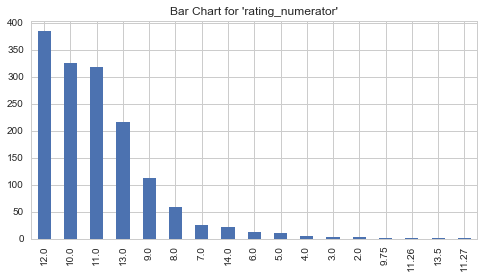

In [240]:
twitter_archive_master.rating_numerator.value_counts().plot(kind="bar",title = "Bar Chart for 'rating_numerator'")

From the above bar-chart, we can see most frequent 'rating_numerator' is 12.0 and its occurred more than 375 times.

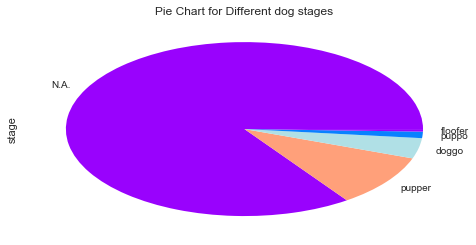

In [241]:
color_theme = ['#9902FD', '#FFA07A', '#B0E0E6','#0981FF']
twitter_archive_master.stage.fillna("N.A.").value_counts().plot(kind="pie",colors=color_theme,title="Pie Chart for Different dog stages")

From the above  pie-chart , we can see dog stage : 'pupper' has the 2nd highest share after stage : N.A.(Not Available)

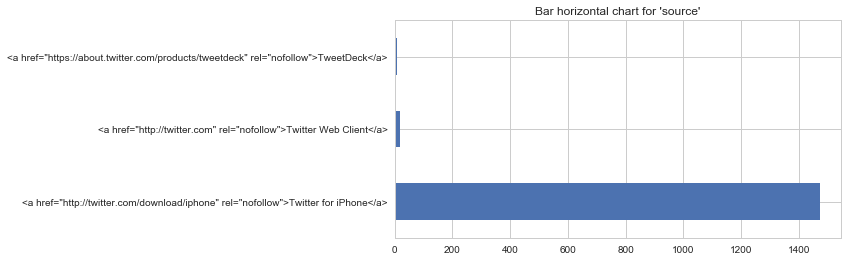

In [242]:
twitter_archive_master.source.value_counts().plot(kind="barh",title="Bar horizontal chart for 'source'")

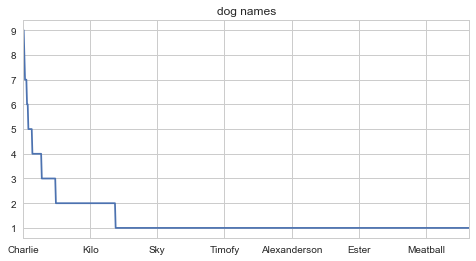

In [243]:
twitter_archive_master.name.value_counts().plot(title="dog names")

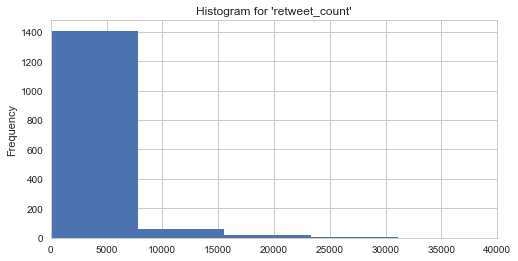

In [244]:
twitter_archive_master.retweet_count.plot(kind="hist",title="Histogram for 'retweet_count'",xlim=(0,40000))

So from the above Histogram we can say, that maximum number of 'retweet_count' exist between 0 to 750 for this dataset

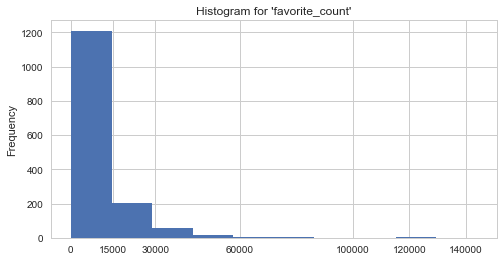

In [245]:
twitter_archive_master.favorite_count.plot(kind="hist",title= "Histogram for 'favorite_count'",xticks=[0,15000,30000,60000,100000,120000,140000])

So from the above Histogram we can say, that maximum number of 'favorite_count' exist between 0 to 15000. Also we can see an outlier.

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


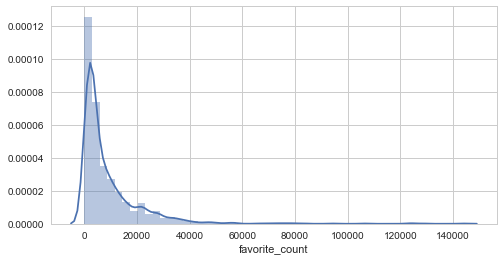

In [246]:
sb.distplot(twitter_archive_master.favorite_count)

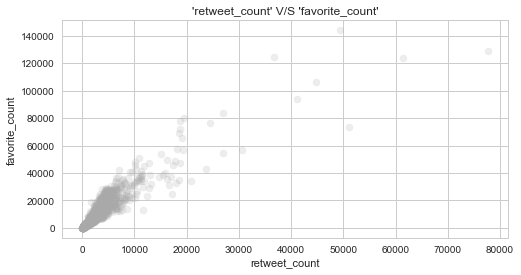

In [247]:
twitter_archive_master.plot(kind="scatter",x="retweet_count",y="favorite_count",c=["darkgrey"],s=50,alpha=0.2,title = "'retweet_count' V/S 'favorite_count'")

Above scatterplot showing relation between 'retweet_count' & 'favorite_count' .And It is a strong relationship as like we have already computed correlation of 0.913633

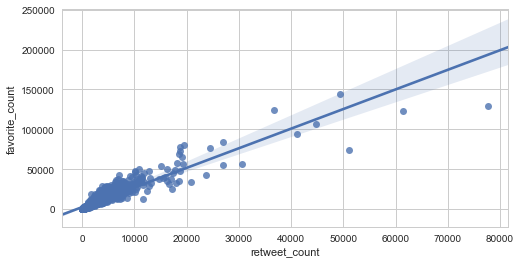

In [248]:
sb.regplot(x="retweet_count",y="favorite_count",data=twitter_archive_master,scatter=True)

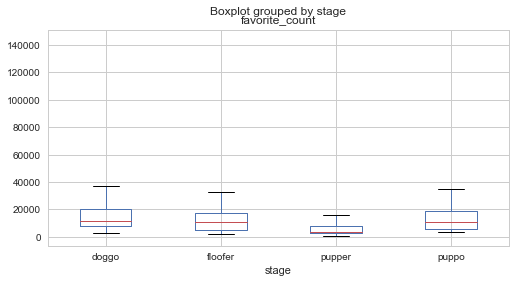

In [249]:
twitter_archive_master.boxplot(column="favorite_count",by="stage")

In [250]:
twitter_archive_master.groupby(["stage"])["favorite_count"].median()

stage
doggo      11502.0
floofer    11090.0
pupper      3327.0
puppo      11112.5
Name: favorite_count, dtype: float64

From last 2 analysis we can say that dog stage : 'doggo' has the highest 'favorite_count' mean value of 11502

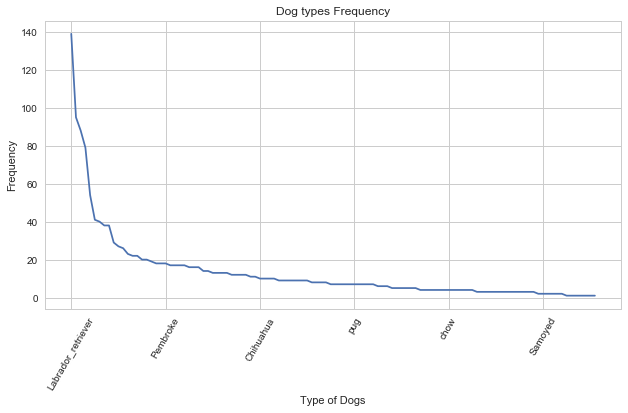

In [251]:
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

ax.plot(twitter_archive_master.type.value_counts().values)


#ax.set_xticks(range(56))

ax.set_xticklabels(twitter_archive_master.type.value_counts().index,rotation=60,fontsize='medium')

ax.set_title('Dog types Frequency')

ax.set_xlabel('Type of Dogs')
ax.set_ylabel('Frequency')

---

####    [[ Reference ]]

https://stackoverflow.com/questions/4897353/regex-to-disallow-more-than-1-dash-consecutively

https://stackoverflow.com/questions/2616974/limit-length-of-characters-in-a-regular-expression

https://stackoverflow.com/questions/26985228/python-regular-expression-match-multiple-words-anywhere

http://docs.tweepy.org/en/v3.2.0/api.html

https://developer.twitter.com/en/docs/basics/response-codes

https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

https://en.wikipedia.org/wiki/Covariance

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html